# Imports

In [1]:
import datetime
from configuration.paths import *

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

from src.datasets.pneumonia_detection_challenge import PneumoniaDetectionChallenge
from src.datasets.chest_xray import ChestXRay
from src.utils.schemes import Scheme
from src.utils.image import Image

# Dataset loading for training

In [2]:
IMAGE_SIZE = [256, 256]

In [3]:
pdc = PneumoniaDetectionChallenge(DATASET_PNEUMONIA_DETECTION_CHALLENGE_PATH, IMAGE_SIZE)

In [4]:
Scheme.dataset_info(pdc)

Train:
 - Normal: 4643
 - Pneumonia: 4536
Test:
 - Normal: 1558
 - Pneumonia: 1476
Val:
 - Normal: 16
 - Pneumonia: 4


In [5]:
x_train, y_train, _ = pdc.load_train_data()
x_train = x_train / 255.0

x_val, y_val, _ = pdc.load_val_data()
x_val = x_val / 255.0

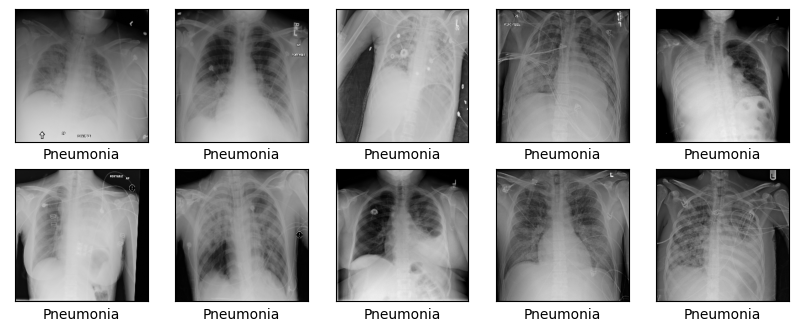

In [6]:
Scheme.labeled_images(x_train, y_train)

# Mdel definition

In [7]:
vgg = VGG16(input_shape = IMAGE_SIZE + [3],
        weights = 'imagenet',
        include_top=False)

for layer in vgg.layers:
  layer.trainable = False

In [8]:
x = tf.keras.layers.Flatten()(vgg.output)
x = tf.keras.layers.Dense(1000, activation='relu')(x)
prediction = tf.keras.layers.Dense(1, activation='sigmoid')(x)

In [9]:
model = tf.keras.models.Model(inputs=vgg.input, outputs=prediction)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [10]:
model.compile(optimizer='adam',
              loss="binary_crossentropy",
              metrics=['binary_accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')])

# Model training

In [11]:
aug = ImageDataGenerator(rotation_range=45, zoom_range=0.3,
						width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
						vertical_flip=True, horizontal_flip=True, fill_mode="nearest")

history = model.fit(aug.flow(x_train, y_train, batch_size=16),
					validation_data=(x_val, y_val),
					epochs=15)

Epoch 1/15
574/574 [==============================] - 96s 160ms/step - loss: 1.0891 - binary_accuracy: 0.6234 - precision: 0.6091 - recall: 0.6152 - val_loss: 0.3984 - val_binary_accuracy: 0.7500 - val_precision: 0.4444 - val_recall: 1.0000
Epoch 2/15
574/574 [==============================] - 82s 143ms/step - loss: 0.5848 - binary_accuracy: 0.7063 - precision: 0.6971 - recall: 0.7270 - val_loss: 0.5382 - val_binary_accuracy: 0.7000 - val_precision: 0.4000 - val_recall: 1.0000
Epoch 3/15
574/574 [==============================] - 82s 143ms/step - loss: 0.5737 - binary_accuracy: 0.7106 - precision: 0.7017 - recall: 0.7205 - val_loss: 0.6059 - val_binary_accuracy: 0.6500 - val_precision: 0.3636 - val_recall: 1.0000
Epoch 4/15
574/574 [==============================] - 82s 143ms/step - loss: 0.5834 - binary_accuracy: 0.6997 - precision: 0.6881 - recall: 0.7181 - val_loss: 0.4306 - val_binary_accuracy: 0.8000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 5/15
574/574 [================

<Figure size 640x480 with 0 Axes>

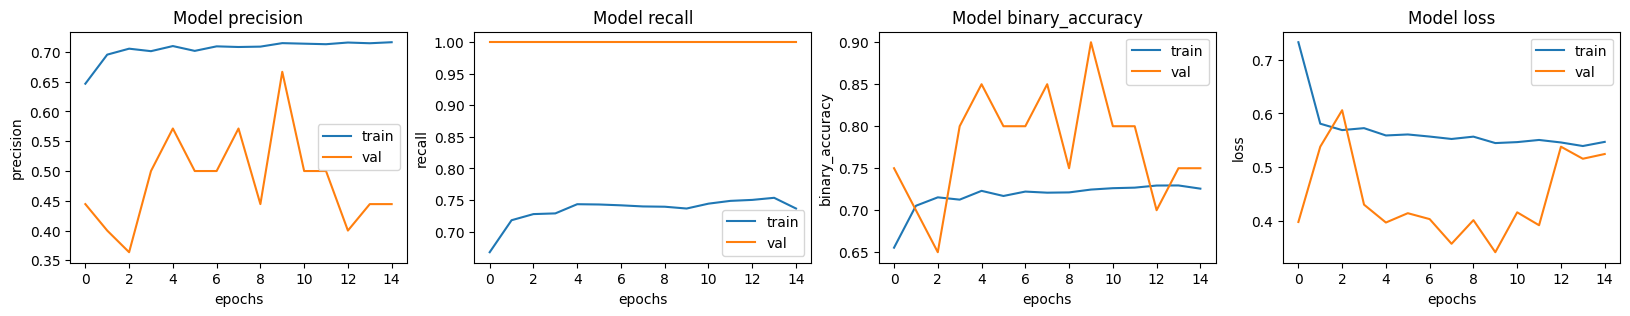

In [12]:
Scheme.training_graphs(history)

In [13]:
del x_train
del y_train

# Evaluating the model

### Pneumonia Detection Challenge

In [14]:
x_test, y_test, images = pdc.load_test_data()
x_test = x_test / 255.0

In [15]:
test_loss, test_accuracy, _, _ = model.evaluate(x_test, y_test)

95/95 [==============================] - 16s 124ms/step - loss: 0.5115 - binary_accuracy: 0.7472 - precision: 0.7050 - recall: 0.8259


In [16]:
predictions = model.predict(x_test)
predictions_rounded = np.round(predictions).astype(int)

In [17]:
images_index = [103, 117, 156, 353, 465, 1615, 1707, 1875, 1951, 2150]
images = [x_test[img] for img in images_index]
labels = [y_test[img] for img in images_index]
predicted_images = [predictions_rounded[img][0] for img in images_index]

Before explaining the images

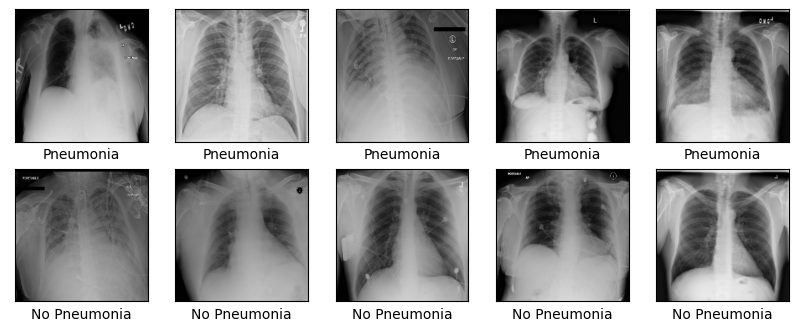

In [18]:
Scheme.labeled_images(images, labels)

Explain the images

In [19]:
explained_images = Image.explain(images, model, IMAGE_SIZE)

100%|██████████| 1000/1000 [00:09<00:00, 109.75it/s]


Green regions -> Supporting the predicted label

Red regions -> Against the predicted label

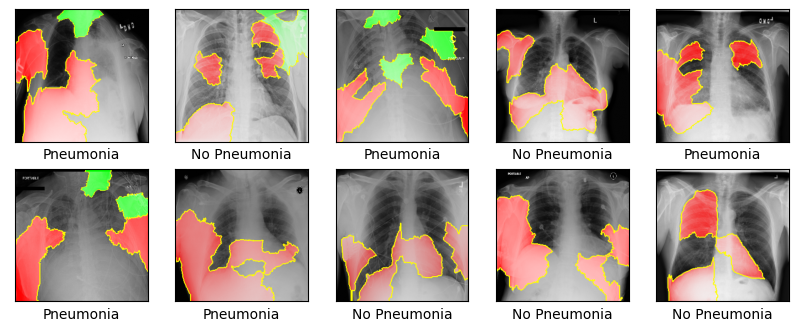

In [20]:
Scheme.labeled_images(explained_images, predicted_images)

<Figure size 640x480 with 0 Axes>

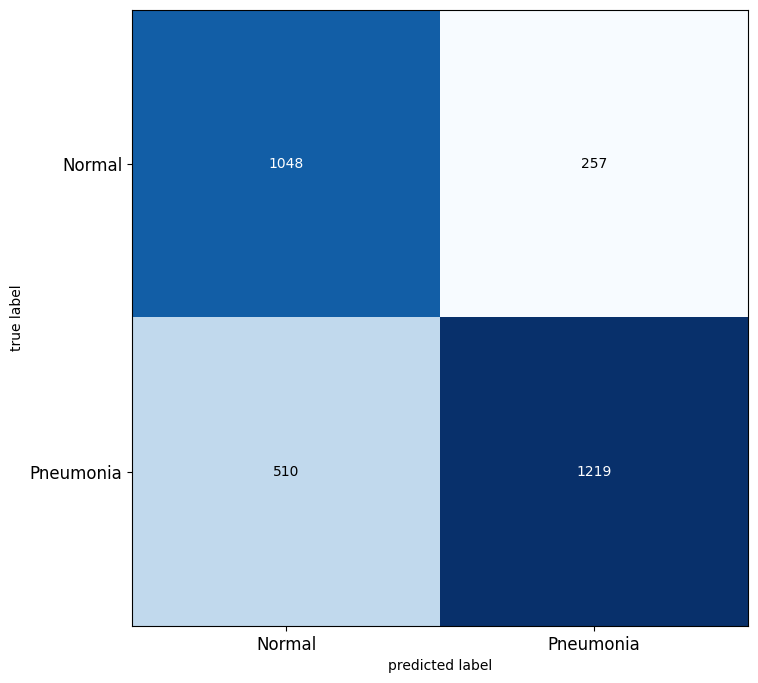

In [21]:
Scheme.confusion_matrix(predictions_rounded, pdc.get_test_df().diagnosis.to_numpy())

### Chest X-Ray

In [22]:
cx = ChestXRay(DATASET_CHEST_XRAY_PATH, IMAGE_SIZE)
x_test, y_test, images = cx.load_test_data()
x_test = x_test / 255.0

In [23]:
test_loss, test_accuracy, _, _ = model.evaluate(x_test, y_test)

20/20 [==============================] - 2s 89ms/step - loss: 0.5257 - binary_accuracy: 0.7756 - precision: 0.9433 - recall: 0.6821 1s - loss: 0.5334 - binary_accuracy: 0.7617 - precision:


In [24]:
predictions = model.predict(x_test)
predictions_rounded = np.round(predictions).astype(int)

In [25]:
images_index = [9, 11, 12, 13, 16, 1, 2, 3, 5, 8]
images = [x_test[img] for img in images_index]
labels = [y_test[img] for img in images_index]
predicted_images = [predictions_rounded[img][0] for img in images_index]

Before explaining the images

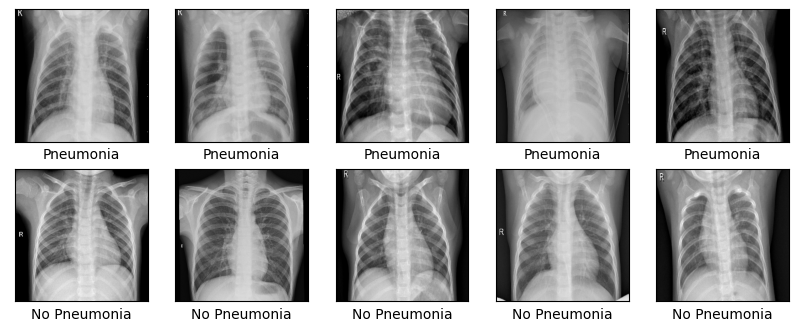

In [26]:
Scheme.labeled_images(images, labels)

Explain the images

In [27]:
explained_images = Image.explain(images, model, IMAGE_SIZE)

100%|██████████| 1000/1000 [00:09<00:00, 101.85it/s]


Green regions -> Supporting the predicted label

Red regions -> Against the predicted label

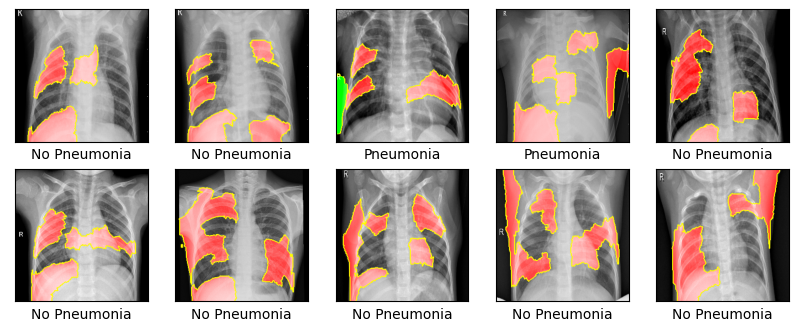

In [28]:
Scheme.labeled_images(explained_images, predicted_images)

<Figure size 640x480 with 0 Axes>

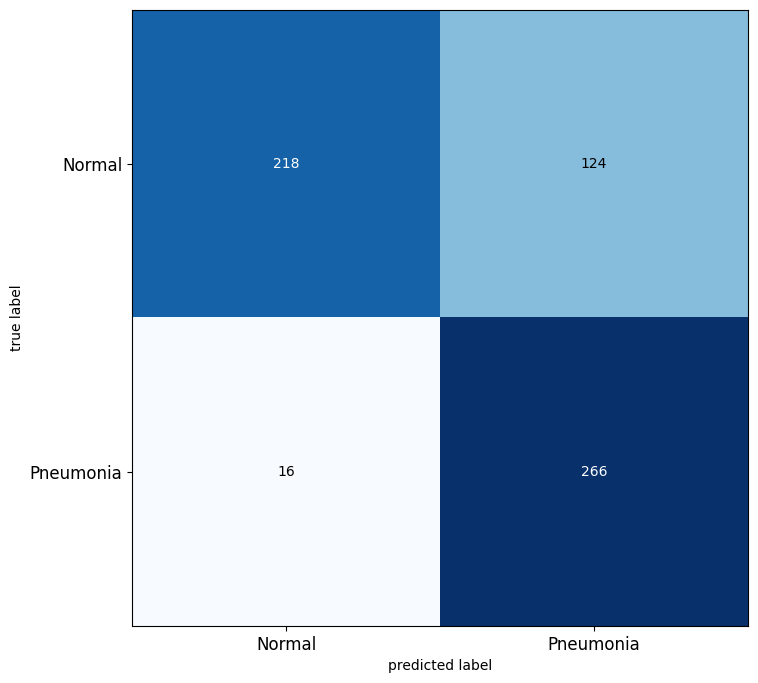

In [29]:
Scheme.confusion_matrix(predictions_rounded, cx.get_test_df(). diagnosis.to_numpy())